In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, first, last, max as _max, min as _min, sum as _sum, avg, input_file_name, regexp_extract, col, log, exp
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Create Spark session with necessary JARs for S3 access
spark = SparkSession.builder \
    .appName("Read from S3") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.568") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
            "com.amazonaws.auth.profile.ProfileCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
    .getOrCreate()


In [ ]:
# Load Parquet data from S3

# df = spark.read.parquet("s3a://cryptospark-dataset/archive/")
df = spark.read.parquet("C:/DATA228")

# Extract symbol from filename (e.g., 1INCH-BTC.parquet), and date from open_time column
df = df.withColumn("symbol", regexp_extract(input_file_name(), r"([^/]+)\.parquet$", 1)) \
    .withColumn("date", to_date("open_time"))

df.printSchema()
df.show(5)

root
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- quote_asset_volume: float (nullable = true)
 |-- number_of_trades: integer (nullable = true)
 |-- taker_buy_base_asset_volume: float (nullable = true)
 |-- taker_buy_quote_asset_volume: float (nullable = true)
 |-- open_time: timestamp_ntz (nullable = true)
 |-- symbol: string (nullable = false)
 |-- date: date (nullable = true)

+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+--------+----------+
|   open|   high|    low|  close|  volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|  symbol|      date|
+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+-----------------------

### Basic Descriptive Statistics

In [ ]:
# Summary statistics for key numeric columns
df.describe(["open", "high", "low", "close", "volume"]).show()

In [ ]:
# Time Range 
df.select(_min("open_time").alias("start_date"), _max("open_time").alias("end_date")).show()

### 1. Data Reduction & Preparation

In [24]:
from pyspark.sql.functions import avg, max, min, sum as _sum

# Aggregate minute-level data into daily level
daily_df = (
    df.groupBy("symbol", "date")
      .agg(
          avg("open").alias("avg_open"),
          avg("close").alias("avg_close"),
          max("high").alias("max_high"),
          min("low").alias("min_low"),
          _sum("volume").alias("total_volume"),
          _sum("number_of_trades").alias("total_trades"),
          _sum("taker_buy_base_asset_volume").alias("buy_volume")
      )
      .cache()
)

In [25]:
# ============================================
# 2. Symbol Selection (High Volume & High Price)
# ============================================
from pyspark.sql.functions import avg

symbol_stats = (
    daily_df.groupBy("symbol")
            .agg(
                avg("total_volume").alias("avg_volume"),
                avg("avg_close").alias("avg_price")
            )
)

# Filter by volume and price thresholds
filtered_symbols = symbol_stats.filter(
    (symbol_stats.avg_volume > 1_000_000) & (symbol_stats.avg_price > 10)
)

# Pick top 3 by average volume
top_symbols = filtered_symbols.orderBy("avg_volume", ascending=False).limit(3)
top_symbols.show()

+------------+--------------------+------------------+
|      symbol|          avg_volume|         avg_price|
+------------+--------------------+------------------+
|   LUNA-BUSD|1.043141477942703...|23.692329510184745|
|   LUNA-USDT| 5.352539523832988E8|24.127279731496017|
|SUSHIUP-USDT| 6.818181314479403E7|16.152223319382767|
+------------+--------------------+------------------+



In [49]:
# ============================================
# 3. Topic A: Volatility & Trend Analysis
# ============================================
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg as moving_avg

# Replace with actual top symbol you want to explore
selected_symbol = "LUNA-USDT"
# selected_symbol = "SUSHIUP-USDT"
symbol_df = daily_df.filter(daily_df.symbol == selected_symbol)

# Volatility = (high - low) / open
symbol_df = symbol_df.withColumn("volatility", (col("max_high") - col("min_low")) / col("avg_open"))

# Moving Averages (7-day and 30-day)
window_7 = Window.orderBy("date").rowsBetween(-6, 0)
window_30 = Window.orderBy("date").rowsBetween(-29, 0)

symbol_df = (
    symbol_df
    .withColumn("ma_7", moving_avg("avg_close").over(window_7))
    .withColumn("ma_30", moving_avg("avg_close").over(window_30))
)


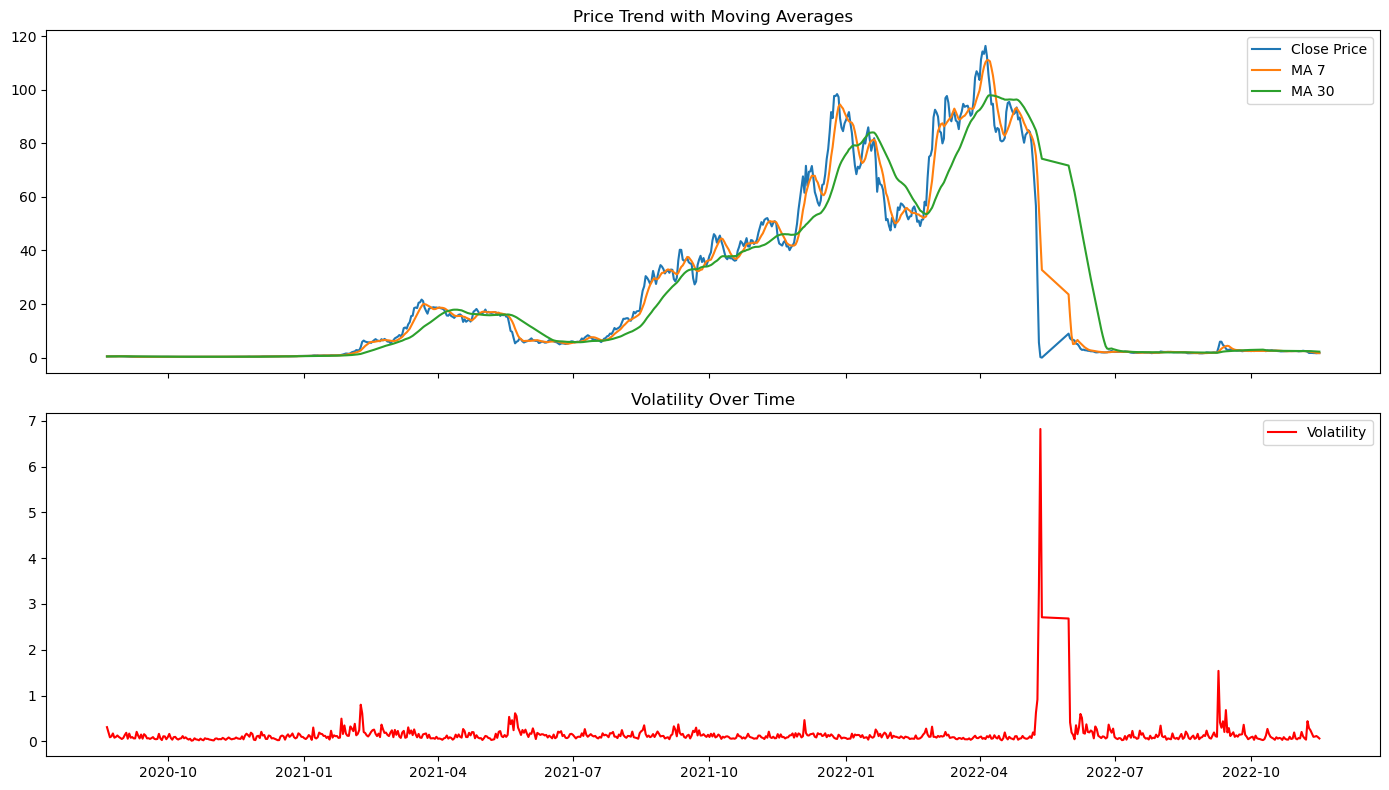

In [50]:
# Convert to Pandas for plotting
pandas_df = symbol_df.select("date", "avg_close", "ma_7", "ma_30", "volatility").toPandas()

# Plot price + MA + volatility
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price trend
axs[0].plot(pandas_df["date"], pandas_df["avg_close"], label="Close Price")
axs[0].plot(pandas_df["date"], pandas_df["ma_7"], label="MA 7")
axs[0].plot(pandas_df["date"], pandas_df["ma_30"], label="MA 30")
axs[0].set_title("Price Trend with Moving Averages")
axs[0].legend()

# Volatility
axs[1].plot(pandas_df["date"], pandas_df["volatility"], color="red", label="Volatility")
axs[1].set_title("Volatility Over Time")
axs[1].legend()

plt.tight_layout()
plt.show()


+-------------------+
| volume_return_corr|
+-------------------+
|-0.5660654920732986|
+-------------------+



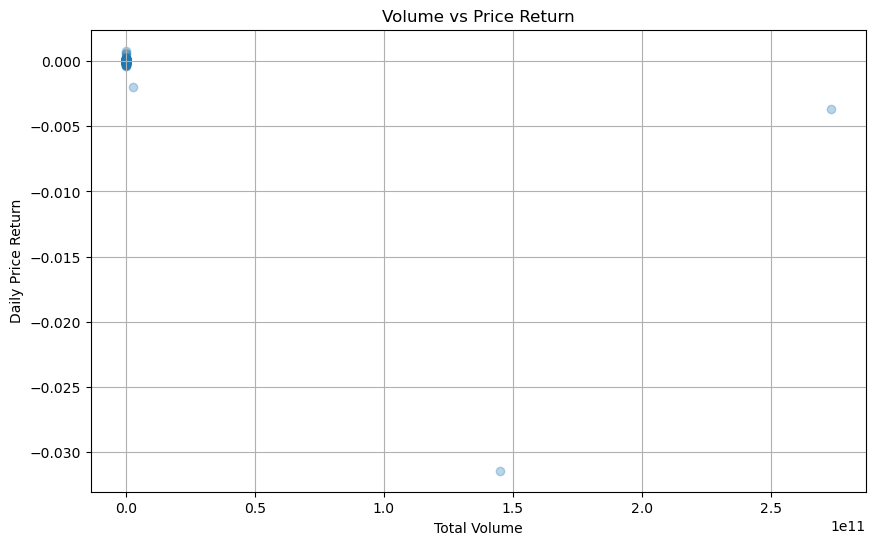

In [51]:
# ============================================
# 4. Topic B: Volume & Price Correlation
# ============================================
# Daily price return
symbol_df = symbol_df.withColumn("price_return", (col("avg_close") - col("avg_open")) / col("avg_open"))

# Correlation
symbol_df.selectExpr("corr(total_volume, price_return) as volume_return_corr").show()

# Convert for plotting
pandas_corr_df = symbol_df.select("total_volume", "price_return", "date", "avg_close").toPandas()

# Scatter plot of volume vs return
plt.figure(figsize=(10, 6))
plt.scatter(pandas_corr_df["total_volume"], pandas_corr_df["price_return"], alpha=0.3)
plt.xlabel("Total Volume")
plt.ylabel("Daily Price Return")
plt.title("Volume vs Price Return")
plt.grid(True)
plt.show()


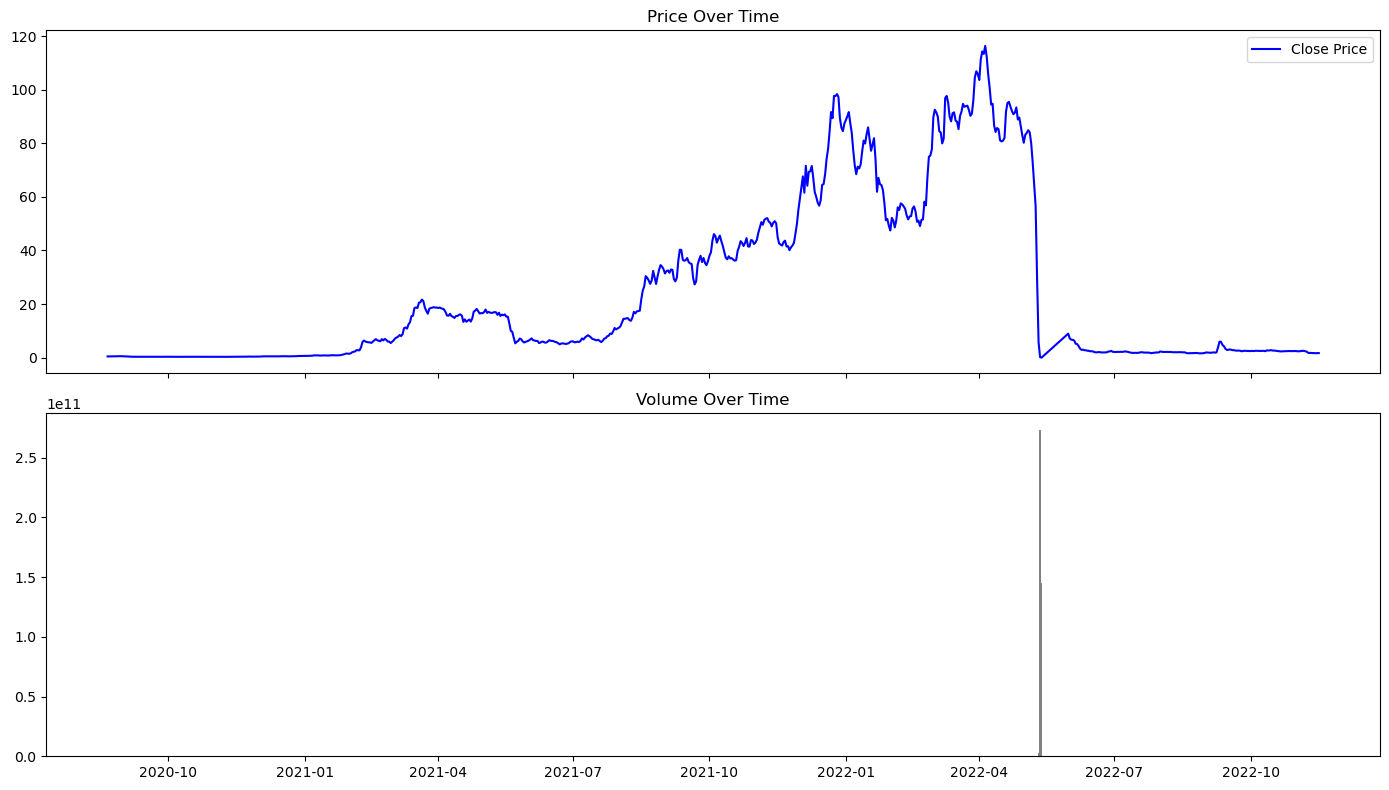

In [52]:
# Sort by date before plotting
pandas_corr_df = pandas_corr_df.sort_values("date")


# Plot: Price and Volume Over Time
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Price line plot
axs[0].plot(pandas_corr_df["date"], pandas_corr_df["avg_close"], label="Close Price", color="blue")
axs[0].set_title("Price Over Time")
axs[0].legend()

# Volume bar plot
axs[1].bar(pandas_corr_df["date"], pandas_corr_df["total_volume"], color="gray")
axs[1].set_title("Volume Over Time")

plt.tight_layout()
plt.show()


In [53]:
# ============================================
# 5. Topic C: Taker Buy Ratio & Bullish Signal Detection (Smoothed)
# ============================================
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, avg as spark_avg

# Step 1: Calculate taker buy ratio
symbol_df = symbol_df.withColumn(
    "taker_buy_ratio",
    col("buy_volume") / col("total_volume")
)

# Step 2: Add 7-day rolling average of taker buy ratio
rolling_window = Window.orderBy("date").rowsBetween(-6, 0)
symbol_df = symbol_df.withColumn(
    "taker_buy_ratio_ma7",
    spark_avg("taker_buy_ratio").over(rolling_window)
)

# Step 3: Define bullish signal: smoothed ratio > 0.6 AND positive return
symbol_df = symbol_df.withColumn(
    "bullish_signal",
    when((col("taker_buy_ratio_ma7") > 0.6) & (col("price_return") > 0), 1).otherwise(0)
)


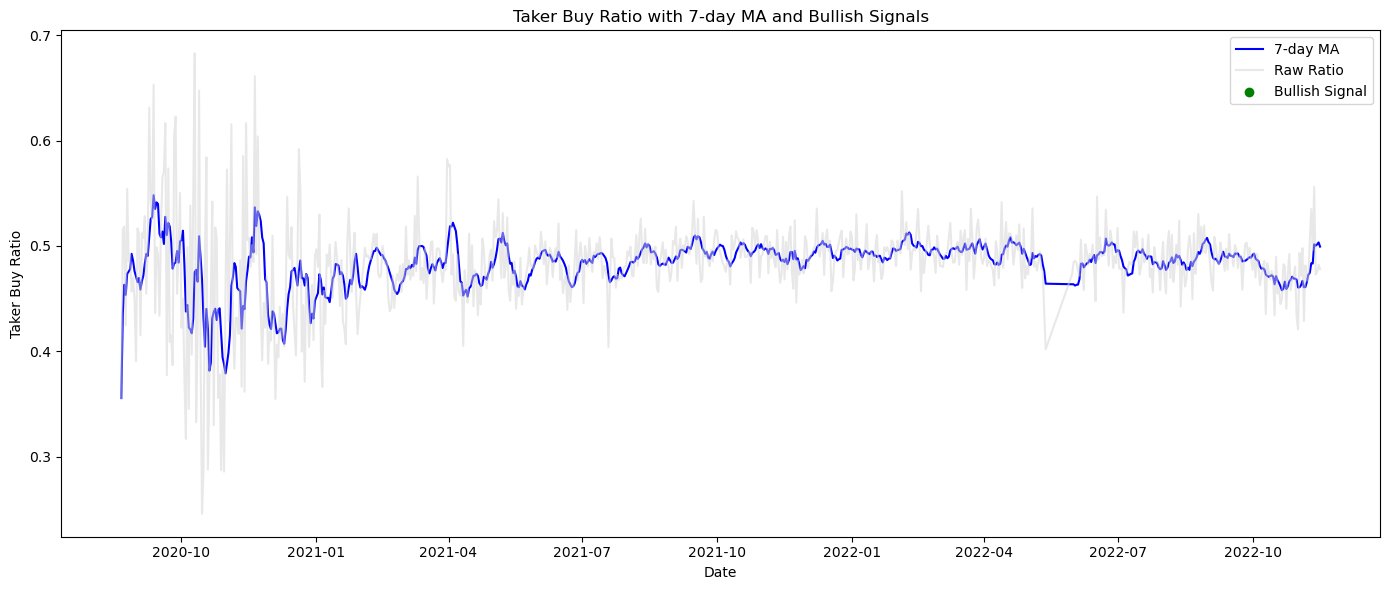

In [54]:
# Step 4: Plot the smoothed taker buy ratio with bullish signals
pandas_signal_df = symbol_df.select(
    "date", "taker_buy_ratio", "taker_buy_ratio_ma7", "bullish_signal"
).toPandas().sort_values("date")

plt.figure(figsize=(14, 6))

# Smoothed ratio line
plt.plot(pandas_signal_df["date"], pandas_signal_df["taker_buy_ratio_ma7"], label="7-day MA", color="blue")

# Raw ratio (optional)
plt.plot(pandas_signal_df["date"], pandas_signal_df["taker_buy_ratio"], label="Raw Ratio", color="lightgray", alpha=0.5)

# Bullish signal markers
plt.scatter(
    pandas_signal_df[pandas_signal_df["bullish_signal"] == 1]["date"],
    pandas_signal_df[pandas_signal_df["bullish_signal"] == 1]["taker_buy_ratio_ma7"],
    color="green", label="Bullish Signal", zorder=5
)

plt.title("Taker Buy Ratio with 7-day MA and Bullish Signals")
plt.xlabel("Date")
plt.ylabel("Taker Buy Ratio")
plt.legend()
plt.tight_layout()
plt.show()


# Preprocessing Section

In [ ]:
df.show(5)

In [ ]:
# Drop unnecessary columns
processed_df = df.drop("quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "open_time")

# Drop rows with nulls in critical columns
processed_df = processed_df.dropna(subset=["open", "high", "low", "close", "volume", "date"])

In [ ]:
processed_df.rdd.getNumPartitions()

In [ ]:
df.select("symbol").distinct().count()

In [ ]:
processed_df = processed_df.withColumn("daily_return", (col("close") - col("open")) / col("open")) \
       .withColumn("volatility", (col("high") - col("low")) / col("open"))

# Define window specification: partition by 'symbol' and order by 'date'
processed_df = processed_df.repartition("symbol").cache()
processed_df.count()  # Forces cache population

In [ ]:
processed_df.rdd.getNumPartitions()

In [ ]:
# Show the first few rows of the processed DataFrame
processed_df.show(5)

In [ ]:
# Save the processed DataFrame to S3 in Parquet format, partitioned by 'symbol'
processed_df.write.mode("overwrite").partitionBy("symbol").parquet("s3a://cryptospark-dataset/daily_return_volatility/")

In [ ]:
# Get the processed DataFrame from S3
processed_df1 = spark.read.parquet("s3a://cryptospark-dataset/daily_return_volatility/")

# Repartition by symbol to improve parallelism for window operations
processed_df1 = processed_df1.repartition("symbol").cache()

In [ ]:
# Cumulative return
#window_spec = Window.partitionBy("symbol").orderBy("date") \
    #.rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Moving Averages (7-day and 30-day)
window_7 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-6, 0)
window_30 = Window.partitionBy("symbol").orderBy("date").rowsBetween(-29, 0)

# Calculate cumulative return and moving averages
processed_df1 = processed_df1.withColumn("ma_7", avg("close").over(window_7)) \
    .withColumn("ma_30", avg("close").over(window_30))
    #.withColumn("cumulative_return", exp(_sum(log(1 + col("daily_return"))).over(window_spec)) - 1) \

In [ ]:
# Lag features (previous day close price, volume)
processed_df1 = processed_df1.withColumn("prev_close", lag("close", 1).over(window_7)) \
                             .withColumn("prev_volume", lag("volume", 1).over(window_7))

In [ ]:
# Price change from previous day
processed_df1 = processed_df1.withColumn("price_change", col("close") - col("prev_close"))

In [ ]:
# Percent change from previous day
processed_df1 = processed_df1.withColumn("percent_change", 
    ((col("close") - col("prev_close")) / col("prev_close")) * 100)

In [ ]:
# Normalized volume (volume relative to 7-day average)
processed_df1 = processed_df1.withColumn("volume_normalized", 
    col("volume") / avg("volume").over(window_7))

In [ ]:
# Bollinger Bands: Compute 7-day std deviation and use it with MA_7
processed_df1 = processed_df1.withColumn("stddev_7", stddev("close").over(window_7)) \
                             .withColumn("bollinger_upper", col("ma_7") + 2 * col("stddev_7")) \
                             .withColumn("bollinger_lower", col("ma_7") - 2 * col("stddev_7"))

In [ ]:
# Show the final DataFrame with new features
processed_df1.show(5)

In [ ]:
processed_df1 = processed_df1.repartition("symbol")

In [ ]:
# Load new preprocessed data into s3
processed_df1.write.mode("overwrite").partitionBy("symbol").parquet("s3a://cryptospark-dataset/processed-data/")